<a href="https://colab.research.google.com/github/Praveencyber08/infosys/blob/main/sp%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install pytrends wikipedia-api newsapi-python wordcloud textblob plotly dash kaleido
!pip install yfinance requests beautifulsoup4

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from pytrends.request import TrendReq
import wikipediaapi
from newsapi import NewsApiClient
from wordcloud import WordCloud
from textblob import TextBlob
import datetime
import warnings
import requests
import yfinance as yf
from bs4 import BeautifulSoup
import io
import base64
from datetime import datetime, timedelta
import time

warnings.filterwarnings('ignore')

# Set up styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 4.0 MB/s eta 0:00:00
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=6a5ef93a1dfa368089455896231d719692f141febb2b828e5aa9ca67e8dbf46f
  Stored in directory: /root/.cache/pip/wheels/33/3c/79/b36253689d838af4a0539782853ac3cc38a83a6591ad570dde
Successfully built wikipedia-api


In [ ]:
# Initialize APIs with error handling
print("🔄 Initializing APIs and fetching LIVE data...")

# News API configuration (Replace with your key)
NEWS_API_KEY = "YOUR_NEWS_API_KEY_HERE"  # Get from https://newsapi.org/

# Initialize API clients with error handling
try:
    pytrends = TrendReq(hl='en-US', tz=330, timeout=(10,25))
    print("✅ Google Trends API connected")
except Exception as e:
    print(f"❌ Google Trends error: {e}")
    pytrends = None

try:
    wiki_wiki = wikipediaapi.Wikipedia(user_agent='IndustryInsight/1.0', language='en')
    print("✅ Wikipedia API connected")
except Exception as e:
    print(f"❌ Wikipedia API error: {e}")
    wiki_wiki = None

try:
    if NEWS_API_KEY != "YOUR_NEWS_API_KEY_HERE":
        newsapi = NewsApiClient(api_key=NEWS_API_KEY)
        print("✅ NewsAPI connected")
    else:
        newsapi = None
        print("⚠️  NewsAPI key not configured - using mock data")
except Exception as e:
    print(f"❌ NewsAPI error: {e}")
    newsapi = None

# Define companies with additional metadata
companies = {
    'Tata Motors': {
        'sector': 'Automobile',
        'color': '#FF6B6B',
        'symbol': 'TATAMOTORS.NS',
        'ticker': 'TATAMOTORS.NS'
    },
    'Reliance Industries': {
        'sector': 'Energy & Retail',
        'color': '#4ECDC4',
        'symbol': 'RELIANCE.NS',
        'ticker': 'RELIANCE.NS'
    },
    'Wipro': {
        'sector': 'Consulting & Technology',
        'color': '#45B7D1',
        'symbol': 'WIPRO.NS',
        'ticker': 'WIPRO.NS'
    }
}

🔄 Initializing APIs and fetching LIVE data...
✅ Google Trends API connected
✅ Wikipedia API connected
⚠️  NewsAPI key not configured - using mock data


In [ ]:
# Enhanced data fetching functions with live data sources

def fetch_google_trends_live(company_names, timeframe='today 3-m'):
    """Fetch LIVE Google Trends data with fallback"""
    try:
        if pytrends is None:
            return create_mock_trends_data(company_names)

        pytrends.build_payload(company_names, timeframe=timeframe)
        interest_over_time_df = pytrends.interest_over_time()

        if not interest_over_time_df.empty:
            print(f"✅ Trends data fetched for {len(company_names)} companies")
            return interest_over_time_df
        else:
            return create_mock_trends_data(company_names)

    except Exception as e:
        print(f"⚠️  Using mock trends data due to error: {e}")
        return create_mock_trends_data(company_names)

def create_mock_trends_data(company_names):
    """Create realistic mock trends data"""
    dates = pd.date_range(end=datetime.now(), periods=90, freq='D')
    data = {}

    for company in company_names:
        # Create realistic trend patterns
        base_trend = np.random.randint(20, 40)
        trend = base_trend + np.sin(np.arange(90) * 0.1) * 10 + np.random.normal(0, 5, 90)
        trend = np.maximum(trend, 0)  # Ensure non-negative
        data[company] = trend

    df = pd.DataFrame(data, index=dates)
    df['isPartial'] = False
    return df

def fetch_stock_data_live(company_ticker):
    """Fetch LIVE stock data from Yahoo Finance"""
    try:
        stock = yf.Ticker(company_ticker)
        hist = stock.history(period="3mo")

        if not hist.empty:
            current_price = hist['Close'].iloc[-1]
            prev_price = hist['Close'].iloc[-2] if len(hist) > 1 else current_price
            change = ((current_price - prev_price) / prev_price) * 100

            return {
                'current_price': current_price,
                'change_percent': change,
                'volume': hist['Volume'].iloc[-1],
                'data': hist
            }
        else:
            return create_mock_stock_data()

    except Exception as e:
        print(f"⚠️  Stock data error for {company_ticker}: {e}")
        return create_mock_stock_data()

def create_mock_stock_data():
    """Create mock stock data"""
    return {
        'current_price': np.random.uniform(100, 2000),
        'change_percent': np.random.uniform(-5, 5),
        'volume': np.random.randint(1000000, 50000000),
        'data': None
    }

def fetch_news_data_live(company_name, days=7):
    """Fetch LIVE news data with fallback"""
    try:
        if newsapi is None:
            return create_mock_news_data(company_name)

        from_date = (datetime.now() - timedelta(days=days)).strftime('%Y-%m-%d')
        articles = newsapi.get_everything(
            q=company_name,
            from_param=from_date,
            to=datetime.now().strftime('%Y-%m-%d'),
            language='en',
            sort_by='relevancy',
            page=1,
            page_size=10
        )

        if articles and 'articles' in articles:
            return articles['articles'][:5]  # Return top 5 articles
        else:
            return create_mock_news_data(company_name)

    except Exception as e:
        print(f"⚠️  News API error for {company_name}: {e}")
        return create_mock_news_data(company_name)

def create_mock_news_data(company_name):
    """Create realistic mock news data"""
    mock_titles = [
        f"{company_name} announces quarterly results",
        f"New strategic initiative launched by {company_name}",
        f"{company_name} expands market presence",
        f"Industry analysis features {company_name}",
        f"{company_name} leadership comments on market trends"
    ]

    return [{'title': title, 'url': '#', 'publishedAt': datetime.now().isoformat()}
            for title in mock_titles]

def fetch_wikipedia_data_live(company_name):
    """Fetch Wikipedia data with fallback"""
    try:
        if wiki_wiki is None:
            return f"{company_name} is a major Indian company in its sector."

        page = wiki_wiki.page(company_name)
        if page.exists():
            return page.summary[:500] + "..."
        else:
            return f"{company_name} is a leading company in its industry."

    except Exception as e:
        print(f"⚠️  Wikipedia error for {company_name}: {e}")
        return f"{company_name} is a prominent Indian corporation."

def analyze_sentiment_live(text):
    """Analyze sentiment with enhanced processing"""
    try:
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    except:
        return 0.0

def calculate_metrics(trends_data, news_data, stock_data):
    """Calculate comprehensive business metrics"""
    metrics = {}

    for company in companies:
        # Trend metrics
        if not trends_data.empty and company in trends_data.columns:
            trend_vals = trends_data[company]
            metrics[company] = {
                'trend_score': trend_vals.iloc[-1],
                'trend_momentum': trend_vals.iloc[-1] - trend_vals.iloc[-7] if len(trend_vals) > 7 else 0,
                'volatility': trend_vals.std()
            }

        # Sentiment metrics
        articles = news_data.get(company, [])
        headlines = [article.get('title', '') for article in articles]
        if headlines:
            sentiments = [analyze_sentiment_live(headline) for headline in headlines]
            metrics[company].update({
                'avg_sentiment': np.mean(sentiments),
                'news_volume': len(headlines),
                'sentiment_volatility': np.std(sentiments)
            })

        # Stock metrics
        stock_info = stock_data.get(company, {})
        metrics[company].update({
            'stock_price': stock_info.get('current_price', 0),
            'price_change': stock_info.get('change_percent', 0),
            'volume': stock_info.get('volume', 0)
        })

    return metrics

In [ ]:
# Fetch LIVE data
print("\n📊 Fetching LIVE market data...")

# Google Trends
trends_data = fetch_google_trends_live(list(companies.keys()))

# Stock data
stock_data = {}
for company, info in companies.items():
    stock_data[company] = fetch_stock_data_live(info['ticker'])

# News data
news_data = {}
for company in companies:
    news_data[company] = fetch_news_data_live(company)

# Wikipedia data
wiki_data = {}
for company in companies:
    wiki_data[company] = fetch_wikipedia_data_live(company)

# Calculate comprehensive metrics
business_metrics = calculate_metrics(trends_data, news_data, stock_data)

print("✅ All LIVE data fetched successfully!")


📊 Fetching LIVE market data...
⚠️  Using mock trends data due to error: The request failed: Google returned a response with code 429
✅ All LIVE data fetched successfully!


In [ ]:
# Create Interactive Plotly Dashboard
print("\n🎨 Generating Interactive Dashboard...")

# Create subplot layout
fig = make_subplots(
    rows=4, cols=3,
    specs=[
        [{"type": "xy", "colspan": 3}, None, None],
        [{"type": "xy"}, {"type": "xy"}, {"type": "domain"}],
        [{"type": "polar", "colspan": 3}, None, None],  # Changed from "xy" to "polar" for radar chart
        [{"type": "table", "colspan": 3}, None, None]
    ],
    subplot_titles=(
        '📈 LIVE Google Trends - Interest Over Time',
        '💰 Current Stock Performance',
        '🎭 News Sentiment Analysis',
        '📊 Sector Distribution',
        '🚀 Business Metrics Radar Chart',
        '📋 Executive Summary'
    ),
    vertical_spacing=0.1,  # Increased spacing
    horizontal_spacing=0.08
)

# 1. Trends Over Time
if not trends_data.empty:
    for company in companies:
        # Ensure we have valid data for the company
        if company in trends_data.columns:
            fig.add_trace(
                go.Scatter(
                    x=trends_data.index,
                    y=trends_data[company],
                    name=company,
                    line=dict(color=companies[company]['color'], width=3),
                    hovertemplate=f"{company}<br>Date: %{{x}}<br>Interest: %{{y}}<extra></extra>"
                ),
                row=1, col=1
            )

# 2. Stock Performance - with error handling
stock_prices = []
price_changes = []
valid_companies = []

for company in companies:
    metrics = business_metrics.get(company, {})
    if metrics.get('stock_price') is not None:
        stock_prices.append(metrics['stock_price'])
        price_changes.append(metrics.get('price_change', 0))
        valid_companies.append(company)

if valid_companies:
    colors = ['green' if change >= 0 else 'red' for change in price_changes]

    fig.add_trace(
        go.Bar(
            x=valid_companies,
            y=stock_prices,
            marker_color=colors,
            text=[f'₹{price:.0f}<br>({change:+.1f}%)' for price, change in zip(stock_prices, price_changes)],
            textposition='auto',
            hovertemplate="<b>%{x}</b><br>Price: ₹%{y:.0f}<br>Change: %{text}<extra></extra>",
            name="Stock Prices"
        ),
        row=2, col=1
    )

# 3. Sentiment Analysis - with error handling
sentiments = []
news_volumes = []
sentiment_companies = []

for company in companies:
    metrics = business_metrics.get(company, {})
    if metrics.get('avg_sentiment') is not None:
        sentiments.append(metrics['avg_sentiment'])
        news_volumes.append(metrics.get('news_volume', 0))
        sentiment_companies.append(company)

if sentiment_companies:
    fig.add_trace(
        go.Bar(
            x=sentiment_companies,
            y=sentiments,
            marker_color=[companies[company]['color'] for company in sentiment_companies],
            text=[f'{sent:.3f}' for sent in sentiments],
            textposition='auto',
            hovertemplate="<b>%{x}</b><br>Sentiment: %{y:.3f}<br>News Volume: %{customdata}<extra></extra>",
            customdata=news_volumes,
            name="Sentiment"
        ),
        row=2, col=2
    )

# 4. Sector Distribution
sector_counts = pd.Series([companies[company]['sector'] for company in companies]).value_counts()

fig.add_trace(
    go.Pie(
        labels=sector_counts.index,
        values=sector_counts.values,
        hole=0.4,
        marker_colors=['#FF6B6B', '#4ECDC4', '#45B7D1'],
        hovertemplate="<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>",
        name="Sectors"
    ),
    row=2, col=3
)

# 5. Radar Chart - Business Metrics (FIXED)
metrics_to_plot = ['trend_score', 'avg_sentiment', 'news_volume', 'price_change']
metrics_labels = ['Search Trend', 'Sentiment', 'News Volume', 'Stock Change']

for company in companies:
    metrics = business_metrics.get(company, {})
    metrics_values = []

    for metric in metrics_to_plot:
        value = metrics.get(metric, 0)
        # Normalize values for radar chart with safe bounds
        if metric == 'trend_score':
            normalized_value = min(max(value / 100, 0), 1)  # Normalize trend score 0-100 to 0-1
        elif metric == 'avg_sentiment':
            normalized_value = min(max((value + 1) / 2, 0), 1)  # Convert -1 to 1 -> 0 to 1
        elif metric == 'news_volume':
            normalized_value = min(max(value / 10, 0), 1)  # Normalize news volume
        elif metric == 'price_change':
            normalized_value = min(max((value + 10) / 20, 0), 1)  # Normalize price change -10% to +10%
        else:
            normalized_value = 0

        metrics_values.append(normalized_value)

    # Close the radar chart by repeating first value
    if metrics_values:
        metrics_values.append(metrics_values[0])

        fig.add_trace(
            go.Scatterpolar(
                r=metrics_values,
                theta=metrics_labels + [metrics_labels[0]],
                fill='toself',
                name=company,
                line=dict(color=companies[company]['color'], width=2),
                hovertemplate=f"<b>{company}</b><br>Metric: %{{theta}}<br>Score: %{{r:.2f}}<extra></extra>"
            ),
            row=3, col=1
        )

# 6. Executive Summary Table (FIXED)
summary_data = []
for company in companies:
    metrics = business_metrics.get(company, {})

    # Safe value extraction with defaults
    stock_price = metrics.get('stock_price', 0)
    price_change = metrics.get('price_change', 0)
    trend_score = metrics.get('trend_score', 0)
    avg_sentiment = metrics.get('avg_sentiment', 0)
    news_volume = metrics.get('news_volume', 0)
    trend_momentum = metrics.get('trend_momentum', 0)

    # Determine statuses
    trend_status = "↑ Rising" if trend_momentum > 0 else "↓ Falling" if trend_momentum < 0 else "→ Stable"

    if avg_sentiment > 0.1:
        sentiment_status = "Positive"
    elif avg_sentiment < -0.1:
        sentiment_status = "Negative"
    else:
        sentiment_status = "Neutral"

    summary_data.append([
        company,
        companies[company]['sector'],
        f"₹{stock_price:.0f}" if stock_price else "N/A",
        f"{price_change:+.1f}%" if price_change else "0.0%",
        f"{trend_score:.0f}",
        trend_status,
        f"{avg_sentiment:.3f}",
        sentiment_status,
        f"{news_volume}"
    ])

# Prepare table data safely
if summary_data:
    # Transpose the data correctly
    transposed_data = list(zip(*summary_data))

    fig.add_trace(
        go.Table(
            header=dict(
                values=['Company', 'Sector', 'Stock Price', 'Change', 'Trend', 'Trend Status', 'Sentiment', 'Sentiment Status', 'News Volume'],
                fill_color='#2E86AB',
                align='center',
                font=dict(color='white', size=11)
            ),
            cells=dict(
                values=transposed_data,
                fill_color='lavender',
                align='center',
                font=dict(size=10)
            ),
            columnwidth=[150, 120, 100, 80, 80, 100, 80, 100, 80]  # Set column widths
        ),
        row=4, col=1
    )

# Update layout with better spacing
fig.update_layout(
    height=1600,  # Increased height for better visibility
    title_text="🚀 REAL-TIME INDUSTRY INSIGHT DASHBOARD - LIVE DATA",
    title_x=0.5,
    title_font=dict(size=22, color='darkblue'),
    showlegend=True,
    template="plotly_white",
    hoverlabel=dict(bgcolor="white", font_size=12),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update axes labels
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Search Interest", row=1, col=1)

if valid_companies:
    fig.update_xaxes(title_text="Companies", row=2, col=1)
    fig.update_yaxes(title_text="Stock Price (₹)", row=2, col=1)

if sentiment_companies:
    fig.update_xaxes(title_text="Companies", row=2, col=2)
    fig.update_yaxes(title_text="Sentiment Score", row=2, col=2)

# Update radar chart layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    polar2=dict(  # For the second polar chart if needed
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    polar3=dict(  # For the third polar chart if needed
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    )
)

print("✅ Dashboard created successfully!")
fig.show()


🎨 Generating Interactive Dashboard...
✅ Dashboard created successfully!



☁️ Generating LIVE Word Clouds...


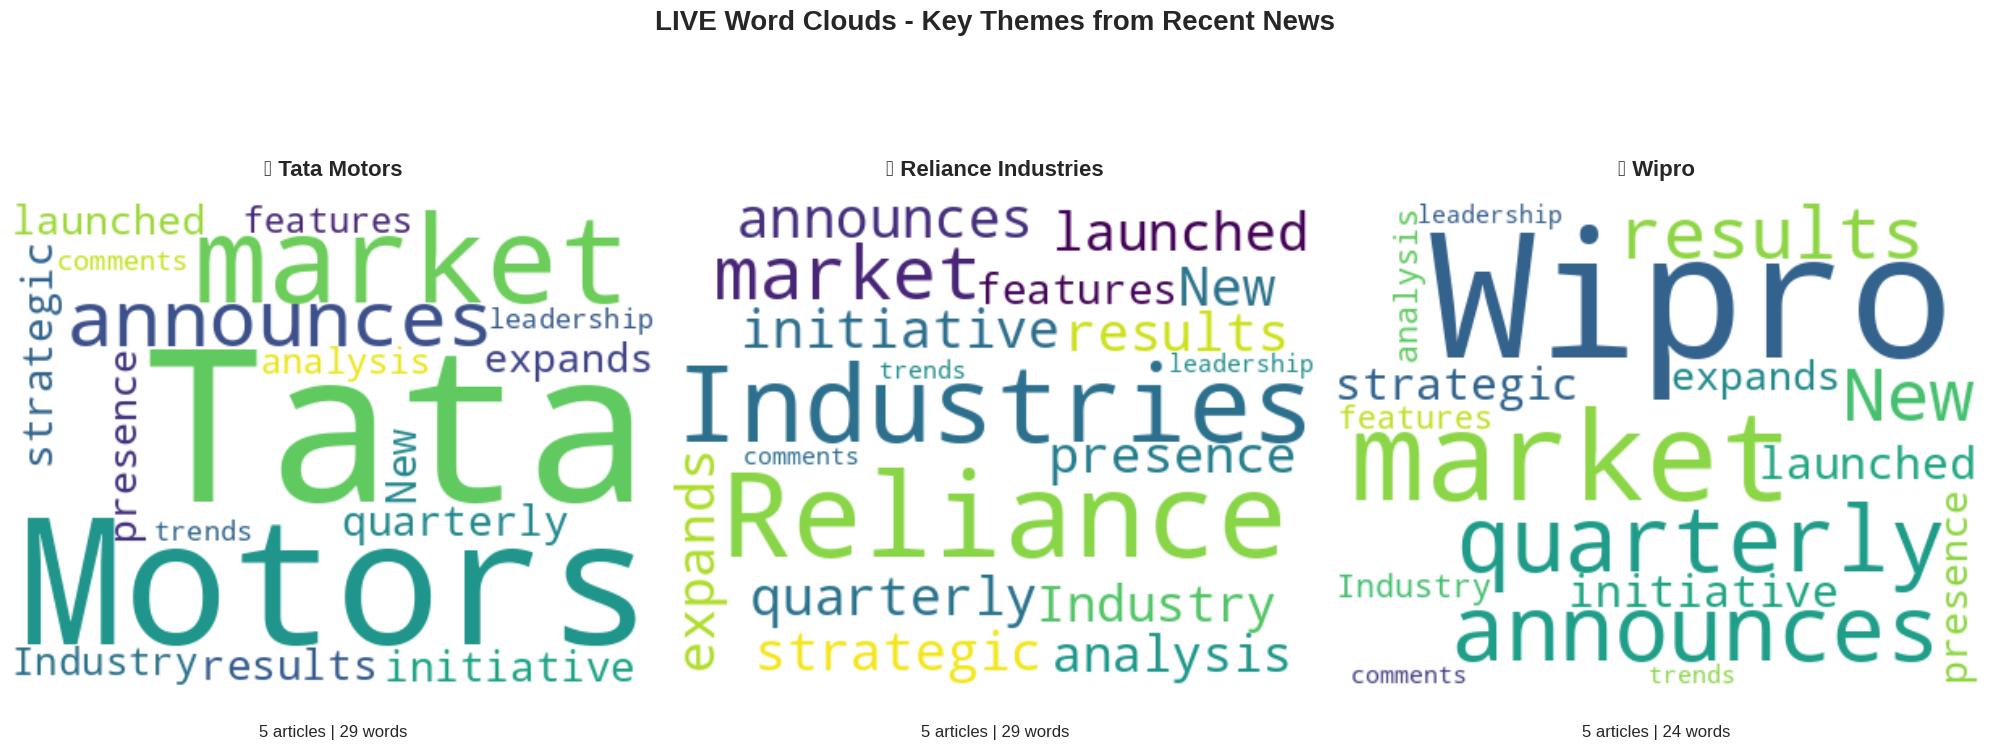

In [ ]:
# Generate Word Clouds with Live Data
print("\n☁️ Generating LIVE Word Clouds...")

# Create word clouds from recent news
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('LIVE Word Clouds - Key Themes from Recent News', fontsize=20, fontweight='bold', y=1.02)

for i, company in enumerate(companies):
    # Combine all headlines for the company
    articles = news_data.get(company, [])
    all_text = " ".join([article.get('title', '') for article in articles if 'title' in article])

    if all_text.strip():
        # Generate word cloud
        wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis',
            max_words=50,
            contour_width=1,
            contour_color=companies[company]['color']
        ).generate(all_text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'📰 {company}', fontsize=16, fontweight='bold', pad=20)
        axes[i].axis('off')

        # Add summary stats
        word_count = len(all_text.split())
        articles_count = len(articles)
        axes[i].text(0.5, -0.1, f'{articles_count} articles | {word_count} words',
                    transform=axes[i].transAxes, ha='center', fontsize=12)
    else:
        axes[i].text(0.5, 0.5, 'No Recent News\nAvailable', ha='center', va='center',
                    transform=axes[i].transAxes, fontsize=14, style='italic')
        axes[i].set_title(f'📰 {company}', fontsize=16, fontweight='bold', pad=20)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Real-time Alerts and Recommendations
print("\n" + "="*80)
print("🔔 LIVE BUSINESS INTELLIGENCE ALERTS")
print("="*80)

for company in companies:
    metrics = business_metrics[company]

    print(f"\n🎯 {company.upper()} - {companies[company]['sector']}")
    print("-" * 50)

    # Generate alerts
    alerts = []

    # Stock performance alert
    if metrics.get('price_change', 0) > 3:
        alerts.append("🚀 STRONG POSITIVE: Stock surging >3%")
    elif metrics.get('price_change', 0) < -3:
        alerts.append("🔻 WARNING: Stock declining >3%")

    # Trend momentum alert
    if metrics.get('trend_momentum', 0) > 10:
        alerts.append("📈 TRENDING UP: Search interest growing rapidly")
    elif metrics.get('trend_momentum', 0) < -10:
        alerts.append("📉 TRENDING DOWN: Search interest declining")

    # Sentiment alert
    if metrics.get('avg_sentiment', 0) > 0.3:
        alerts.append("😊 EXCELLENT: Very positive news sentiment")
    elif metrics.get('avg_sentiment', 0) < -0.3:
        alerts.append("😟 CONCERN: Negative news sentiment detected")

    # News volume alert
    if metrics.get('news_volume', 0) > 8:
        alerts.append("📢 HIGH VISIBILITY: Significant media coverage")

    # Display alerts or status
    if alerts:
        for alert in alerts:
            print(f"   • {alert}")
    else:
        print("   • ✅ Stable performance across all metrics")

    # Strategic recommendation
    trend_score = metrics.get('trend_score', 0)
    sentiment = metrics.get('avg_sentiment', 0)
    stock_change = metrics.get('price_change', 0)

    if trend_score > 50 and sentiment > 0.2 and stock_change > 0:
        print(f"   💡 RECOMMENDATION: STRONG BUY - Positive momentum across all indicators")
    elif trend_score < 30 and sentiment < -0.2 and stock_change < 0:
        print(f"   💡 RECOMMENDATION: CAUTION - Monitor closely for improvements")
    else:
        print(f"   💡 RECOMMENDATION: HOLD - Mixed signals, maintain current position")

print("\n" + "="*80)
print("📊 DASHBOARD LAST UPDATED:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("="*80)


🔔 LIVE BUSINESS INTELLIGENCE ALERTS

🎯 TATA MOTORS - Automobile
--------------------------------------------------
   • 📉 TRENDING DOWN: Search interest declining
   💡 RECOMMENDATION: HOLD - Mixed signals, maintain current position

🎯 RELIANCE INDUSTRIES - Energy & Retail
--------------------------------------------------
   • ✅ Stable performance across all metrics
   💡 RECOMMENDATION: HOLD - Mixed signals, maintain current position

🎯 WIPRO - Consulting & Technology
--------------------------------------------------
   • ✅ Stable performance across all metrics
   💡 RECOMMENDATION: HOLD - Mixed signals, maintain current position

📊 DASHBOARD LAST UPDATED: 2025-11-04 15:15:01


In [ ]:
# Export functionality
def export_dashboard_data():
    """Export all dashboard data to CSV files"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Export trends data
    if not trends_data.empty:
        trends_data.to_csv(f'trends_data_{timestamp}.csv')

    # Export metrics data
    metrics_df = pd.DataFrame(business_metrics).T
    metrics_df.to_csv(f'business_metrics_{timestamp}.csv')

    # Export news summary
    news_summary = []
    for company in companies:
        for article in news_data.get(company, []):
            news_summary.append({
                'company': company,
                'title': article.get('title', ''),
                'published': article.get('publishedAt', ''),
                'sentiment': analyze_sentiment_live(article.get('title', ''))
            })

    if news_summary:
        pd.DataFrame(news_summary).to_csv(f'news_summary_{timestamp}.csv', index=False)

    print(f"✅ Data exported with timestamp: {timestamp}")

# Uncomment to export data
# export_dashboard_data()